#Тестирование модели

##Подготовка окружения

Монтируем google диск.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Переходим в папку проекти и устанавливаем необходимые библиотеки.

In [0]:
cd /content/drive/My Drive/Colab Notebooks/models/research

/content/drive/My Drive/Colab Notebooks/models/research


In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-lxml is already the newest version (4.2.1-1).
python-pil is already the newest version (5.1.0-1).
python-tk is already the newest version (2.7.15~rc1-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [0]:
!protoc object_detection/protos/*.proto --python_out=.
!export PYTHONPATH=$PYTHONPATH:pwd:pwd/slim
import os
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/Colab Notebooks/models/research/:/content/drive/My Drive/Colab Notebooks/models/research/slim/'
!export PYTHONPATH="$PYTHONPATH:/content/drive/My Drive/Colab Notebooks/models/research/slim"
!python setup.py build
!python setup.py install

running build
running build_py
copying object_detection/protos/anchor_generator_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/eval_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/faster_rcnn_box_coder_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/matcher_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying object_detection/protos/faster_rcnn_pb2.py -> build/lib.linux-x86_64-2.7/object_detection/protos
copying obj

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

%matplotlib inline

#import sys
#sys.path.append('content/drive/My Drive/Colab Notebooks/models/research/object_detection') # point to your tensorflow dir
#sys.path.append('content/drive/My Drive/Colab Notebooks/models/research/object_detection/slim') # point ot your slim dir

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Указываю пути до файла модели и лейблов.

In [0]:
PATH_TO_PROJ = '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/'


MODEL_NAME = 'bless_rng'

PATH_TO_FROZEN_GRAPH = PATH_TO_PROJ + MODEL_NAME + '/frozen_inference_graph.pb'

PATH_TO_LABELS = PATH_TO_PROJ + 'legacy/training/' + 'gtsdb_label_map.pbtxt'

NUM_CLASSES = 3

Загружаю frozen graph модели в память.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Загружаю лейблы.

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Распознаются 3 класса: запретительный, обязательный, опасность.



In [0]:
category_index

{1: {'id': 1, 'name': u'prohibitory'},
 2: {'id': 2, 'name': u'mandatory'},
 3: {'id': 3, 'name': u'danger'}}

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Распознование

Создаю пути к тестовым изображениям.

In [0]:
PATH_TO_TEST_IMAGES_DIR = '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 5)]
TEST_IMAGE_PATHS += [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(1, 6)]

IMAGE_SIZE = (12, 8)
TEST_IMAGE_PATHS

['/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image1.jpg',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image2.jpg',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image3.jpg',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image4.jpg',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image1.png',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image2.png',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image3.png',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image4.png',
 '/content/drive/My Drive/Colab Notebooks/models/research/object_detection/test_images/image5.png']

Функция отображения результата работы модели.

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Получаем дескрипторы входных и выходных тензоров
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # Обработка одного изображения
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe нужен для перевода макси из координат окна в координаты изображения.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Запуск inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # Конвертация в float32 numpy arrays
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Распознование 10-ти тестовых изображений.

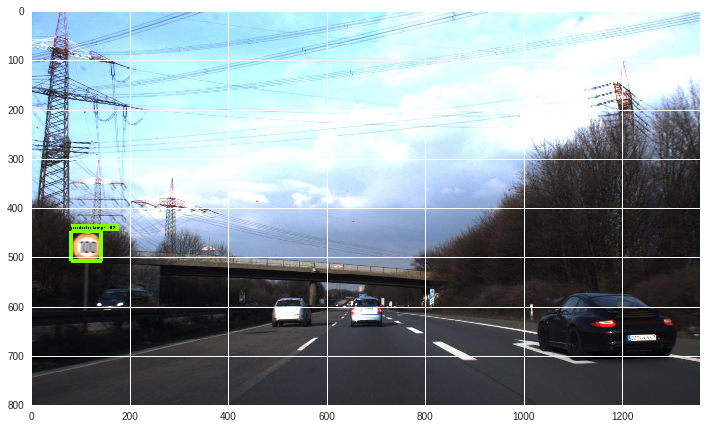

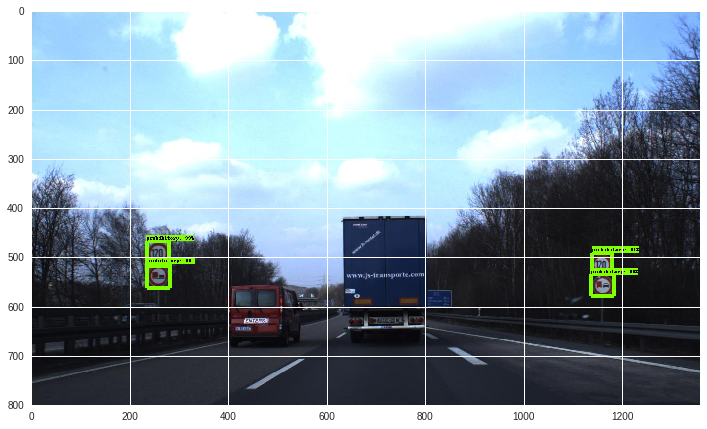

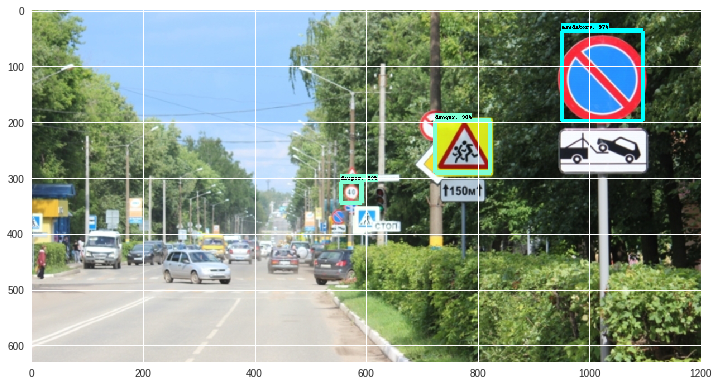

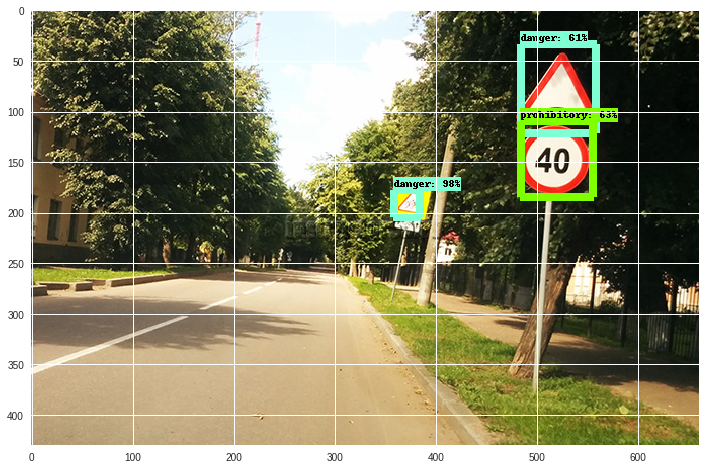

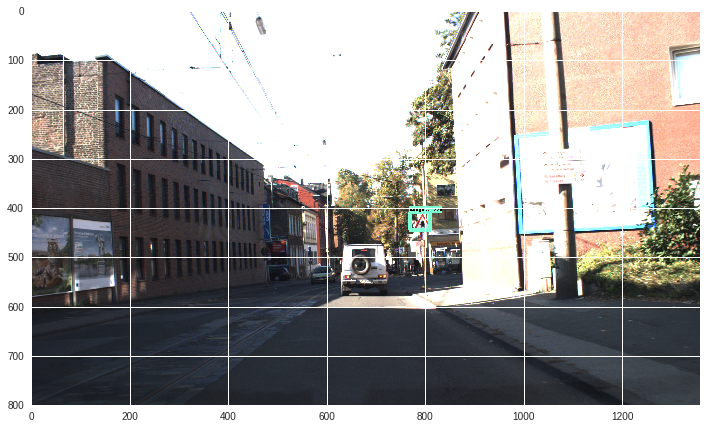

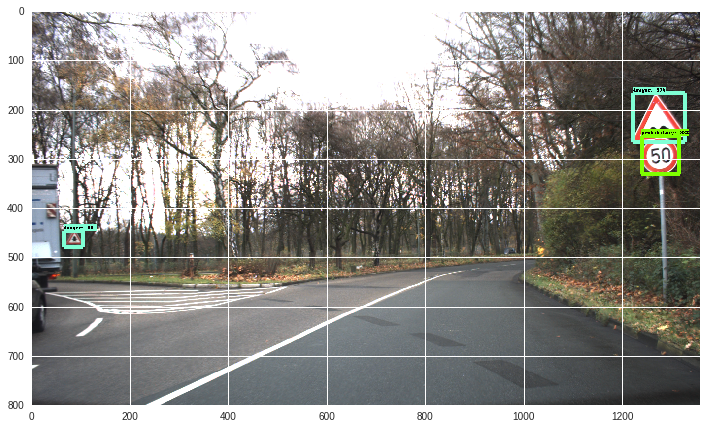

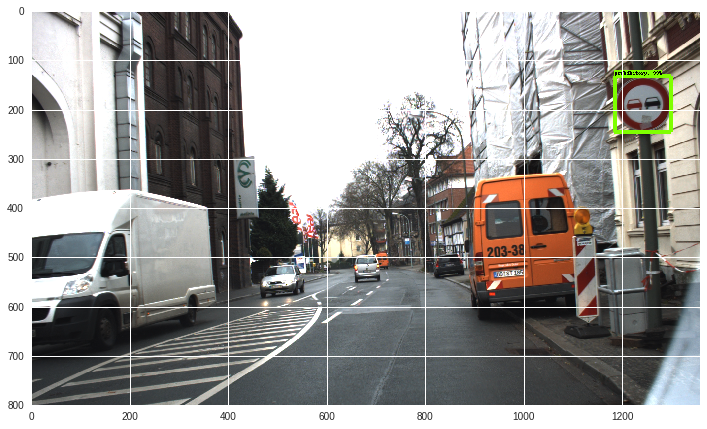

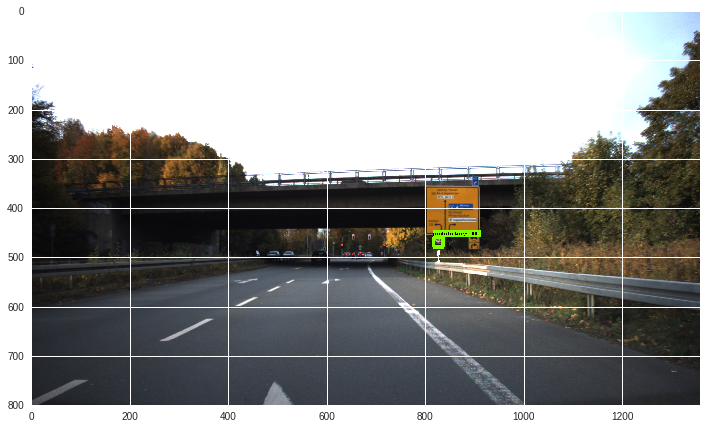

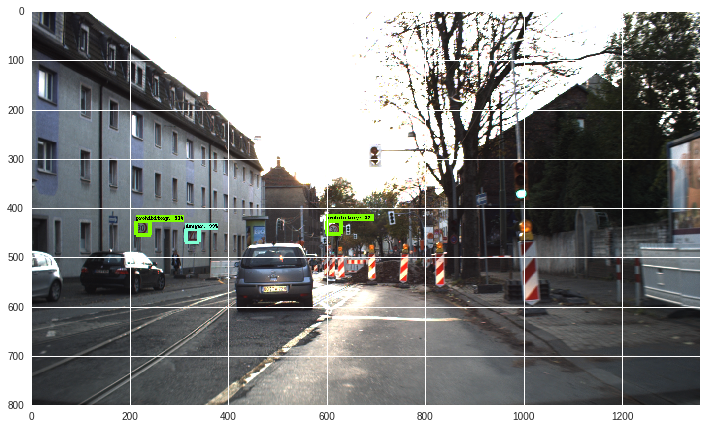

In [0]:
for image_path in TEST_IMAGE_PATHS:
  # Загружаем изображение
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image)
  # Разворачиваем размеры изобр под входные размеры модели: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Распознование.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Нужно для правильной визуализации.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)